In [1]:
%matplotlib inline

import copy
from datetime import date
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import random
import sys
import time
import torch as pt

sys.path.insert(0, '..')

from numpy import exp, log
from scipy.linalg import expm, inv, solve_banded

from utilities import plot_control_for_DoubleWell1d, plot_loss_logs
#from problems import DoubleWell
from solver import Solver
from function_space import MySequential, DenseNet

%load_ext autoreload
%autoreload 2

device = pt.device('cpu')

In [2]:
class LLGC():
    def __init__(self, name='LLGC', d=1, off_diag=0, T=5, seed=42):

        pt.manual_seed(seed)
        self.name = name
        self.d = d
        self.T = T
        self.A = (-pt.eye(self.d) + off_diag * pt.randn(self.d, self.d)).to(device)
        self.B = (pt.eye(self.d) + off_diag * pt.randn(self.d, self.d)).to(device)
        self.alpha = pt.ones(self.d, 1).to(device)
        self.X_0 = pt.zeros(self.d).to(device)

        if ~np.all(np.linalg.eigvals(self.A.cpu().numpy()) < 0):
            print('not all EV of A are negative')

    def b(self, x):
        return pt.mm(self.A, x.t()).t()

    def sigma(self, x):
        return self.B

    def h(self, t, x, y, z):
        return 0.5 * pt.sum(z**2, dim=1)

    def g(self, x):
        return pt.mm(x, self.alpha)[:, 0]

    def u_true(self, x, t):
        return -self.sigma(x).cpu().numpy().T.dot(expm(self.A.cpu().numpy().T * (self.T - t)).dot(
            self.alpha.cpu().numpy()) * np.ones(x.shape).T)

    def v_true(self, x, t):
        delta_t = 0.001
        N = int(np.floor((self.T - t) / delta_t)) + 1
        Sigma_n = np.zeros([self.d, self.d])
        for t_n in np.linspace(t, self.T, N):
            Sigma_n += (expm(self.A.cpu().numpy() * t_n)
                        .dot(self.sigma(np.zeros([self.d, self.d])).cpu())
                        .dot(self.sigma(np.zeros([self.d, self.d])).t().cpu())
                        .dot(expm(self.A.cpu().numpy().T * t_n))) * delta_t
        return ((expm(self.A.cpu().numpy() * (self.T - t)).dot(x.t()).T).dot(self.alpha.cpu().numpy())
                - 0.5 * self.alpha.cpu().numpy().T.dot(Sigma_n.dot(self.alpha.cpu())))

In [ ]:
var_CE = []
var_CE_detach = []
var_CE_detach_selection = []
var_g = []
var_var = []
mean_CE = []
mean_CE_detach = []
mean_CE_detach_selection = []
mean_g = []
mean_var = []

detach_forward = False
adaptive_forward_process = False

L = 1

with pt.no_grad():

    for d in range(1, 16, 2): #range(10, 41, 10)
        print(d)

        T = 1

        llgc = LLGC(d=d, off_diag=0.1, T=T, seed=random.randint(0, 99999))

        problem = llgc

        X_0 = problem.X_0
        delta_t_np = 0.005
        lr = 0.05
        L = 300
        K = 5 * 10**7
        loss_method = 'variance'
        print_every = 1

        delta_t = pt.tensor(delta_t_np).to(device) # step size
        sq_delta_t = pt.sqrt(delta_t).to(device)
        N = int(np.floor(T / delta_t_np)) # number of steps 

        Phis = []

        #z_n = MySequential(d_in=d + 1, d_out=d, lr=lr).to(device)
        z_n = DenseNet(d_in=d + 1, d_out=d, lr=lr).to(device)
        Phis = [z_n]

        for phi in Phis:
            phi.train()

        loss_log = []
        u_L2_loss = []
        times = []

        def b(x):
            return problem.b(x)

        def sigma(x):
            return problem.sigma(x)

        def h(t, x, y, z):
            return problem.h(t, x, y, z)

        def g(x):
            return problem.g(x)

        def u_true(x, t):
            return problem.u_true(x, t)

        def v_true(x, t):
            return problem.v_true(x, t)

        def loss_function(X, Y, Z_sum):
            if loss_method == 'moment':
                return (Y - g(X)).pow(2).mean()
            elif loss_method == 'variance':
                return (Y - g(X)).pow(2).mean() - (Y - g(X)).mean().pow(2)
            elif loss_method == 'relative_entropy':
                return (Z_sum + g(X)).mean()
            elif loss_method == 'cross_entropy':
                return (Y * pt.exp(-g(X) + Y.detach())).mean()

        def initialize_training_data():
            X = X_0.repeat(K, 1).to(device)
            Y = pt.zeros(K).to(device)

            Z_sum = pt.zeros(K).to(device)
            u_L2 = pt.zeros(K).to(device)

            return X, Y, Z_sum, u_L2 

        def zero_grad():
            for phi in Phis:
                phi.adam.zero_grad()

        def gradient_descent():
            for phi in Phis:
                phi.adam.step()

        def Z_n_(X, n):
            t_X = pt.cat([pt.ones([X.shape[0], 1]).to(device) * n * delta_t, X], 1)
            return z_n(t_X)

        def Z_n(X, t):
            n = int(np.ceil(t / delta_t))
            return Z_n_(X, n)

        X, Y0, Z_sum, u_L2 = initialize_training_data()
        Y = Y0

        for n in range(N):
            xi = pt.randn(K, d).to(device)

            Z = Z_n_(X, n)
            c = pt.zeros(d, 1).to(device)
            if adaptive_forward_process is True:
                c = -Z.t()
            if detach_forward is True:
                c = c.detach()
            X = (X + (b(X) + pt.mm(sigma(X), c).t()) * delta_t
                 + pt.mm(sigma(X), xi.t()).t() * sq_delta_t)
            Y = (Y + (h(delta_t * n, X, Y, Z) + pt.sum(Z * c.t(), 1)) * delta_t
                 + pt.sum(Z * xi, 1) * sq_delta_t)

        var_g.append((pt.exp(-g(X))).var().item())
        mean_g.append((pt.exp(-g(X))).mean().item())
        
        var_CE.append((Y * pt.exp(-g(X))).var().item())
        mean_CE.append((Y * pt.exp(-g(X))).mean().item())
        var_CE_detach.append((Y * pt.exp(-g(X) + Y.detach())).var().item())
        mean_CE_detach.append((Y * pt.exp(-g(X) + Y.detach())).mean().item())
        
        val = (Y * pt.exp(-g(X) + Y.detach()))
        val = val[pt.abs(val) < 100]
        var_CE_detach_selection.append(pt.sqrt(pt.var(val)).item())
        mean_CE_detach_selection.append(pt.abs(pt.mean(val)).item())
        
        var_var.append(((Y - g(X) - (Y - g(X)).mean()).pow(4).mean() - (Y - g(X)).var().pow(2)).item())
        mean_var.append(pt.var(Y - g(X)).mean().item())
        
        print(np.sqrt(np.array(var_CE[-1])) / np.abs(np.array(mean_CE[-1])))

1
3.055058873534641
3
14.755972677838194
5
13.547010983982759
7


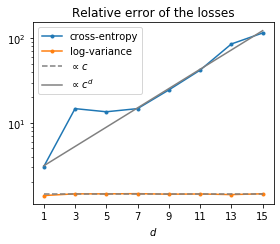

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
d_range = np.arange(1, 16, 2)
ax.plot(d_range, np.sqrt(np.array(var_CE)) / np.abs(np.array(mean_CE)), '.', ls='-', markevery=1, label='cross-entropy')
ax.plot(d_range, np.sqrt(np.array(var_var)) / np.array(mean_var), '.', ls='-', markevery=1, label='log-variance')
ax.plot(d_range, 1.45 * np.ones(8), '--', color='grey', label=r'$\propto c$')
ax.plot(d_range, 2.4 * 1.30**d_range , color='grey', label=r'$\propto c^{d}$')
ax.set_xticks(d_range)
ax.legend()
ax.set_yscale('log')
ax.set_xlabel(r'$d$')
ax.set_title('Relative error of the losses');
fig.tight_layout()
#fig.savefig('img/rel_error_dimension_4.pdf')

In [60]:
np.sqrt(np.array(var_CE)) / np.abs(np.array(mean_CE))

array([  3.05505887,  14.75597268,  13.54701098,  14.75985107,
        24.52242451,  42.00820742,  85.52074092, 115.31012523])

In [61]:
np.sqrt(np.array(var_var)) / np.array(mean_var)

array([1.39002746, 1.4561878 , 1.4557624 , 1.4640088 , 1.442332  ,
       1.45106495, 1.42646312, 1.45825795])

## Another run

In [23]:
np.sqrt(np.array(var_CE)) / np.abs(np.array(mean_CE))

array([  6.72783328,   5.15783922,  49.78432854, 113.53854956,
        27.21789754, 225.23979772, 605.50830375])

In [24]:
np.sqrt(np.array(var_var)) / np.array(mean_var)

array([1.55225075, 1.42513461, 1.50300627, 1.4374404 , 1.43226808,
       1.44646332, 1.45077835])

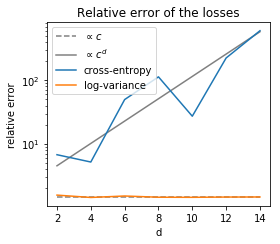

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
d_range = np.arange(2, 15, 2)
ax.plot(d_range, 1.45 * np.ones(7), '--', color='grey', label=r'$\propto c$')
ax.plot(d_range, 2 * 1.5**d_range , color='grey', label=r'$\propto c^{d}$')
ax.plot(d_range, np.sqrt(np.array(var_CE)) / np.abs(np.array(mean_CE)), label='cross-entropy')
#ax.plot(d_range, np.sqrt(np.array(var_CE_detach)) / np.abs(np.array(mean_CE_detach)), label='cross entropy detach')
#ax.plot(d_range, np.sqrt(np.array(var_CE_detach_selection)) / np.abs(np.array(mean_CE_detach_selection)), label='cross entropy detach selection')
ax.plot(d_range, np.sqrt(np.array(var_var)) / np.array(mean_var), label='log-variance')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('d')
ax.set_ylabel('relative error')
ax.set_title('Relative error of the losses');
fig.tight_layout()
#fig.savefig('img/rel_error_dimension_2.pdf')

## Variances

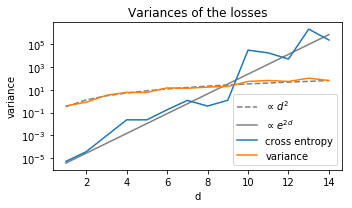

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
d_range = np.arange(1, 15)
ax.plot(d_range, d_range**2 / 3, '--', color='grey', label=r'$\propto d^2$')
ax.plot(d_range, np.exp(2 * d_range) / 2000000, color='grey', label=r'$\propto e^{2d}$')
ax.plot(d_range, var_CE, label='cross entropy')
ax.plot(d_range, var_var, label='variance')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('d')
ax.set_ylabel('variance')
ax.set_title('Variances of the losses');
fig.tight_layout()
#fig.savefig('img/variances_losses_dimension.pdf')